In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import seaborn as sns
import optuna
import warnings
import re
from scipy.stats import gamma
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
from tensorflow import feature_column
import math

In [2]:
train = pd.read_csv(r'/Users/Henry/Downloads/widsdatathon2024-challenge2/train.csv', index_col='patient_id')
test = pd.read_csv(r'/Users/Henry/Downloads/widsdatathon2024-challenge2/test.csv', index_col='patient_id')
print(train)

           patient_race  payer_type patient_state  patient_zip3     Region  \
patient_id                                                                   
268700              NaN  COMMERCIAL            AR           724      South   
484983            White         NaN            IL           629    Midwest   
277055              NaN  COMMERCIAL            CA           925       West   
320055         Hispanic    MEDICAID            CA           900       West   
190386              NaN  COMMERCIAL            CA           934       West   
...                 ...         ...           ...           ...        ...   
588544         Hispanic    MEDICAID            PA           191  Northeast   
393047              NaN  COMMERCIAL            TX           757      South   
790904              NaN  COMMERCIAL            CA           928       West   
455518              NaN  COMMERCIAL            MI           481    Midwest   
379418         Hispanic    MEDICAID            CA           900 

In [3]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='purple')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_zip3,int64,13173,751,5.701055,0,0.000000,568.530859,275.758485,100.000000,330.000000,557.000000,832.000000,995.000000
patient_age,int64,13173,67,0.508616,0,0.000000,59.271313,13.218883,18.000000,50.000000,59.000000,67.000000,91.000000
metastatic_diagnosis_period,int64,13173,366,2.778410,0,0.000000,96.515221,108.969873,0.000000,3.000000,44.000000,181.000000,365.000000
population,float64,13173,751,5.701055,0,0.000000,20651.373928,13840.379638,635.550000,9160.340000,18952.780000,30021.280000,71374.130000
density,float64,13173,747,5.670690,0,0.000000,1776.872376,3876.061897,0.920000,163.150000,700.340000,1666.520000,29851.690000
age_median,float64,13173,594,4.509223,0,0.000000,40.542676,4.031027,20.600000,37.190000,40.640000,42.940000,54.570000
age_under_10,float64,13173,450,3.416078,0,0.000000,11.104988,1.511534,0.000000,10.150000,11.000000,12.140000,17.680000
age_10_to_19,float64,13173,472,3.583087,0,0.000000,12.857587,1.952248,6.310000,11.650000,12.900000,13.910000,35.300000
age_20s,float64,13173,519,3.939877,0,0.000000,13.297375,3.390472,5.930000,11.000000,12.530000,14.970000,62.100000
age_30s,float64,13173,457,3.469217,0,0.000000,12.893557,2.410845,1.500000,11.270000,12.400000,14.130000,25.470000


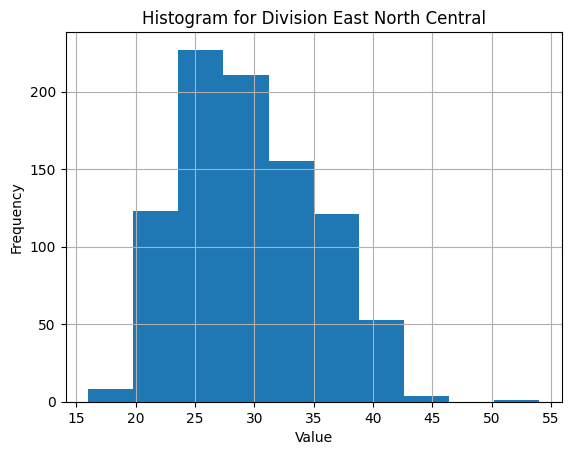

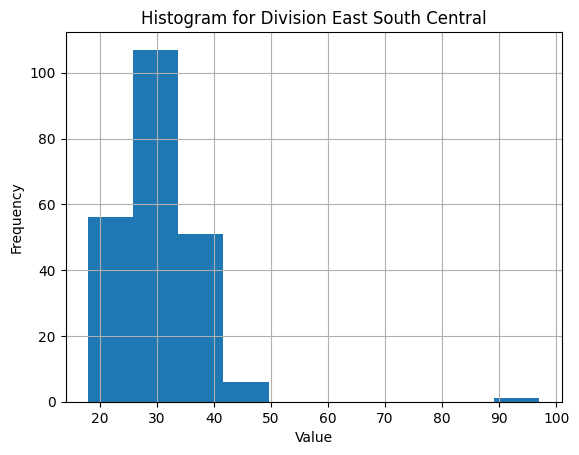

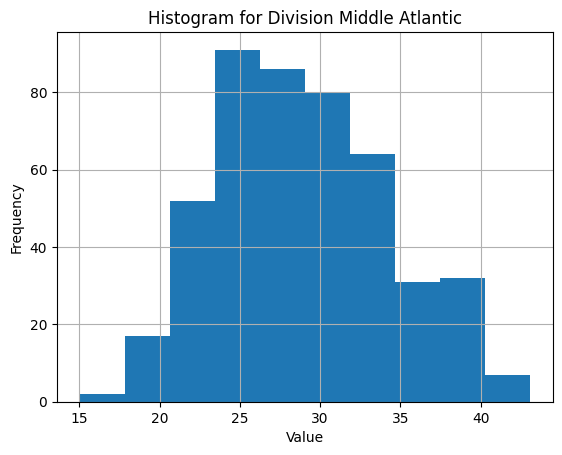

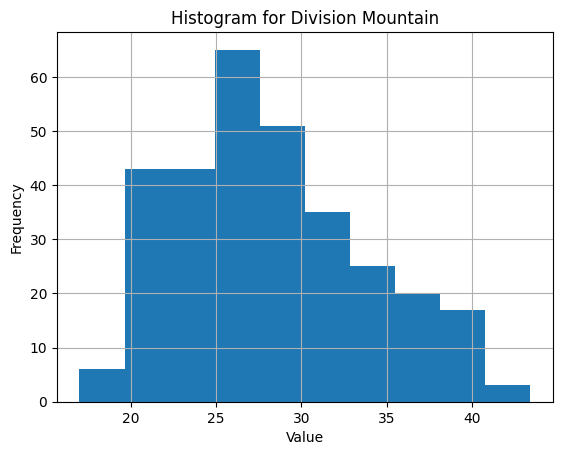

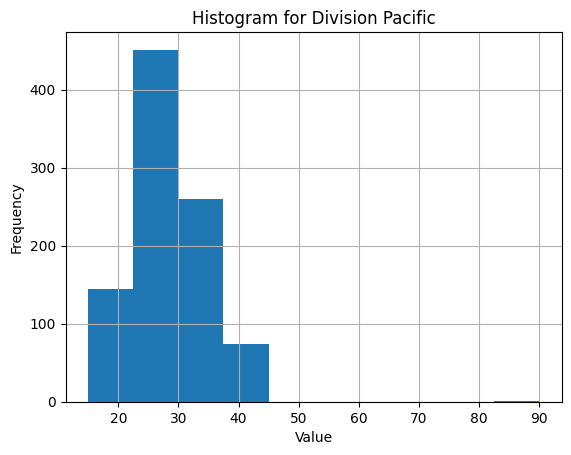

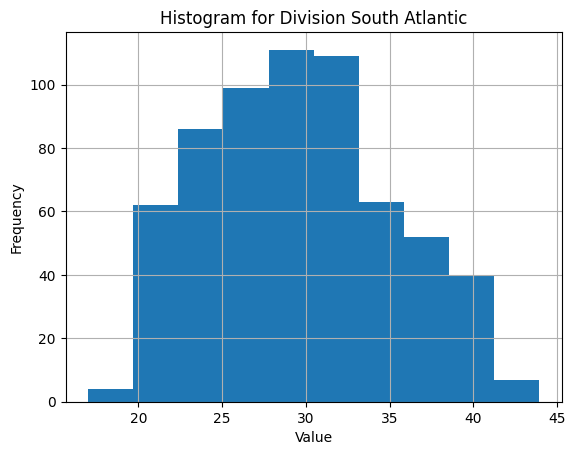

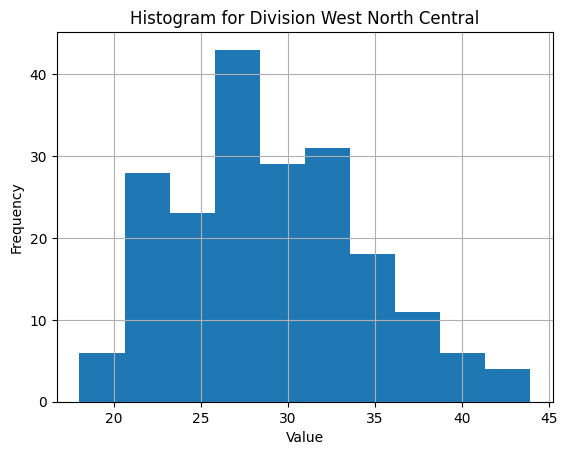

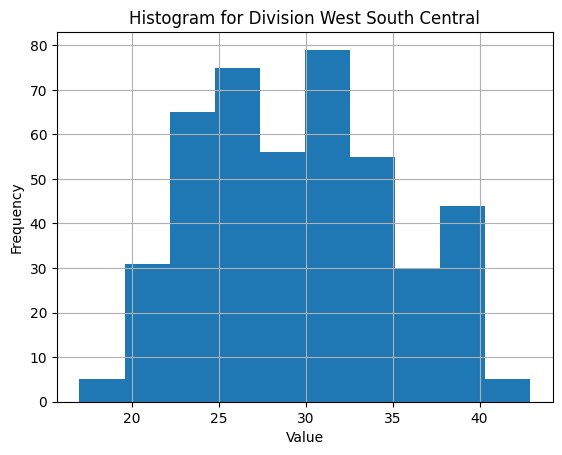

In [4]:
train_nonullbmi = train.copy()
train_nonullbmi.dropna(subset=['bmi'], inplace=True)
grouped_data = train_nonullbmi.groupby('Division')

# Iterate over each group (unique zipcode) and plot a histogram
for division, group in grouped_data:
    plt.figure()  # Create a new figure for each histogram
    group['bmi'].hist()
    plt.title(f'Histogram for Division {division}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [5]:
'''
train_eastnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East North Central"]
train_eastsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East South Central"]
train_middleatlantic = train_nonullbmi[train_nonullbmi["Division"]=="Middle Atlantic"]
train_mountain = train_nonullbmi[train_nonullbmi["Division"]=="Mountain"]
train_pacific = train_nonullbmi[train_nonullbmi["Division"]=="Pacific"]
train_southatlantic = train_nonullbmi[train_nonullbmi["Division"]=="South Atlantic"]
train_westnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West North Central"]
train_westsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West South Central"]
train_bmimask = train["bmi"].isnull()

training = train.loc[train_bmimask]


training.loc[train["Division"] == "East North Central", "bmi"] = np.median(train_eastnorthcentral["bmi"])
training.loc[train["Division"] == "East South Central", "bmi"] = np.median(train_eastsouthcentral["bmi"])
training.loc[train["Division"] == "Middle Atlantic", "bmi"] = np.median(train_middleatlantic["bmi"])
training.loc[train["Division"] == "Mountain", "bmi"] = np.median(train_mountain["bmi"])
training.loc[train["Division"] == "Pacific", "bmi"] = np.median(train_pacific["bmi"])
training.loc[train["Division"] == "South Atlantic", "bmi"] = np.median(train_southatlantic["bmi"])
training.loc[train["Division"] == "West North Central", "bmi"] = np.median(train_westnorthcentral["bmi"])
training.loc[train["Division"] == "West South Central", "bmi"] = np.mean(train_westsouthcentral["bmi"])

train = pd.concat([training, train_nonullbmi])
train = train[train['bmi']<50]
grouped_data_train = train.groupby('Division')          
for division, traingroup in grouped_data_train:
    plt.figure()  # Create a new figure for each histogram
    traingroup['bmi'].hist()
    plt.title(f'Histogram for Division {division}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
'''

'\ntrain_eastnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East North Central"]\ntrain_eastsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East South Central"]\ntrain_middleatlantic = train_nonullbmi[train_nonullbmi["Division"]=="Middle Atlantic"]\ntrain_mountain = train_nonullbmi[train_nonullbmi["Division"]=="Mountain"]\ntrain_pacific = train_nonullbmi[train_nonullbmi["Division"]=="Pacific"]\ntrain_southatlantic = train_nonullbmi[train_nonullbmi["Division"]=="South Atlantic"]\ntrain_westnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West North Central"]\ntrain_westsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West South Central"]\ntrain_bmimask = train["bmi"].isnull()\n\ntraining = train.loc[train_bmimask]\n\n\ntraining.loc[train["Division"] == "East North Central", "bmi"] = np.median(train_eastnorthcentral["bmi"])\ntraining.loc[train["Division"] == "East South Central", "bmi"] = np.median(train_eastsouthcentral["bmi"])\ntrainin

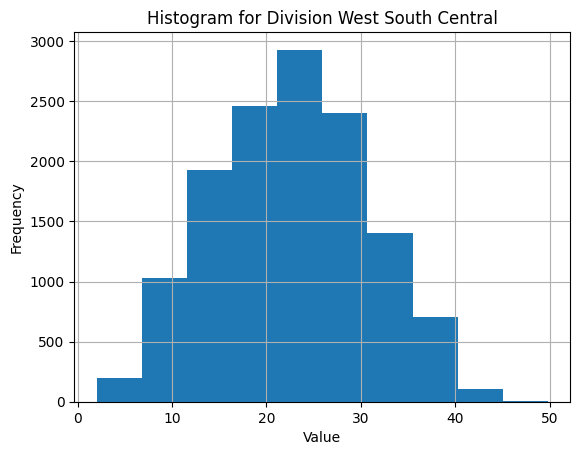

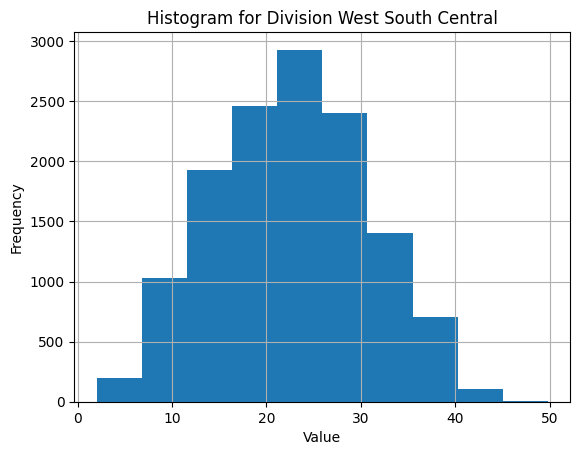

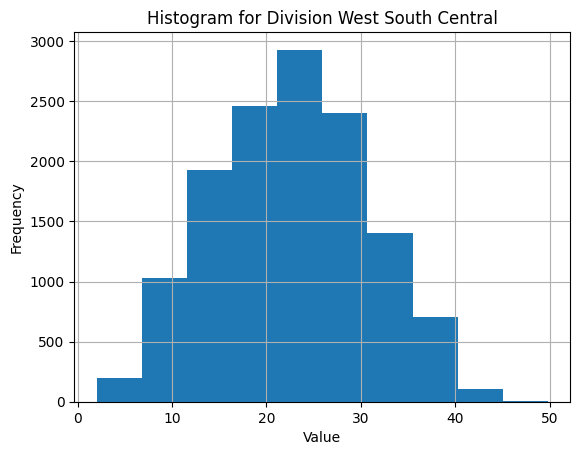

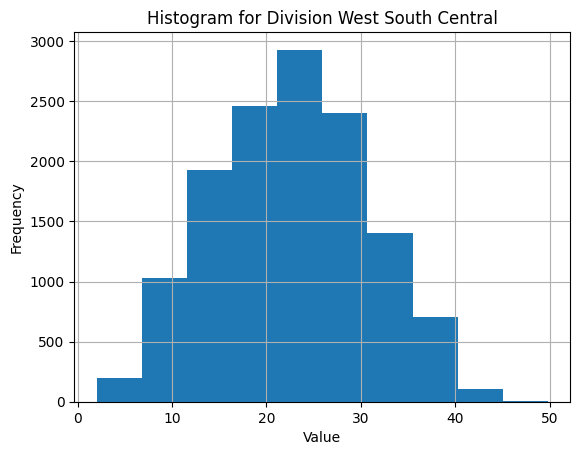

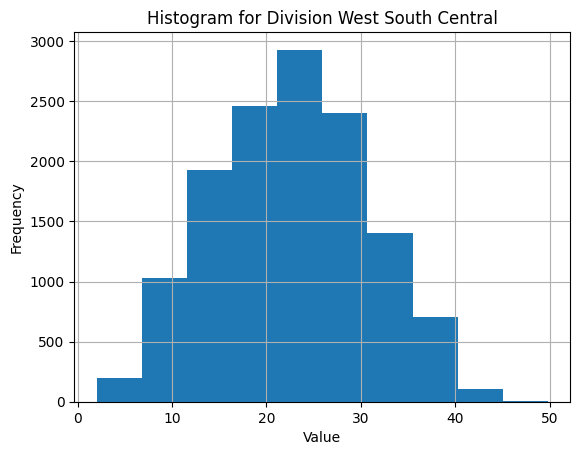

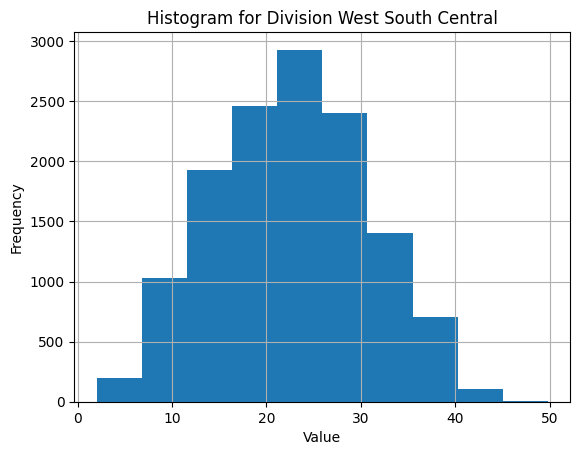

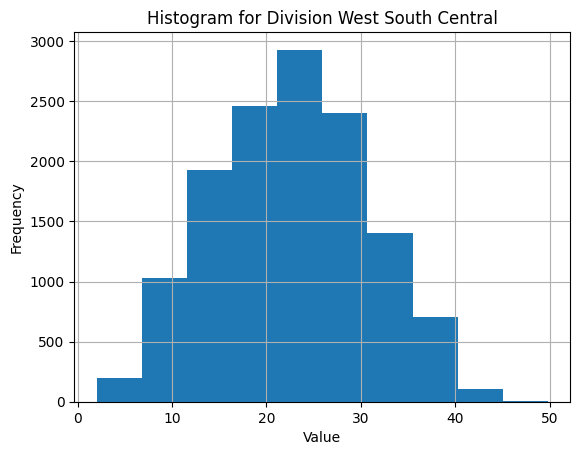

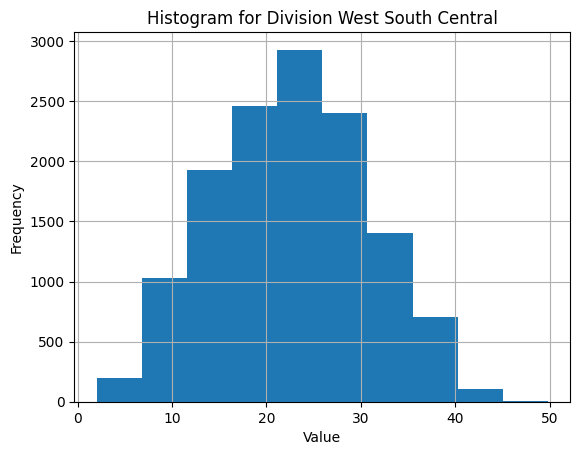

In [6]:
train_eastnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East North Central"]
train_eastsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="East South Central"]
train_middleatlantic = train_nonullbmi[train_nonullbmi["Division"]=="Middle Atlantic"]
train_mountain = train_nonullbmi[train_nonullbmi["Division"]=="Mountain"]
train_pacific = train_nonullbmi[train_nonullbmi["Division"]=="Pacific"]
train_southatlantic = train_nonullbmi[train_nonullbmi["Division"]=="South Atlantic"]
train_westnorthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West North Central"]
train_westsouthcentral = train_nonullbmi[train_nonullbmi["Division"]=="West South Central"]


train_bmimask = train["bmi"].isnull()
shape, loc, scale = gamma.fit(train_eastnorthcentral['bmi'])
training = train.loc[train_bmimask]
training.loc[train["Division"] == "East North Central", "bmi"] = np.random.gamma(shape=shape, scale=scale, size=2107)

modeled = pd.DataFrame()

grouped_data_train = train.groupby('Division')          
for division, trainingroup in grouped_data_train:
    division_word = division
    division = division.replace(" ", "")
    division = division.lower()
    variable = f'train_{division}'
    shape, loc, scale = gamma.fit(locals()[variable]['bmi'])
    training = train.loc[train_bmimask]
    training.loc[train["Division"] == f"{division_word}", "bmi"] = np.random.gamma(shape=shape, scale=scale, size=len(training.loc[train["Division"] == f"{division_word}", "bmi"]))
    modeled = pd.concat([training, modeled])

train = pd.concat([modeled, train_nonullbmi])
train = train[train['bmi']<50]
grouped_data_train = train.groupby('Division')          
for division, trainingroup in grouped_data_train:    
    plt.figure()  # Create a new figure for each histogram
    train['bmi'].hist()
    plt.title(f'Histogram for Division {division_word}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

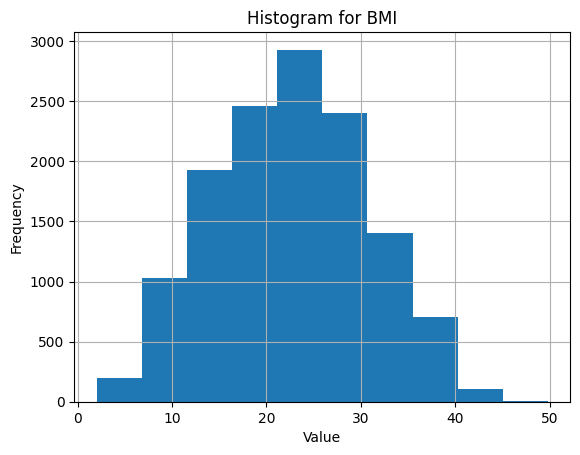

In [7]:
plt.figure()  # Create a new figure for each histogram
train['bmi'].hist()
plt.title(f'Histogram for BMI')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

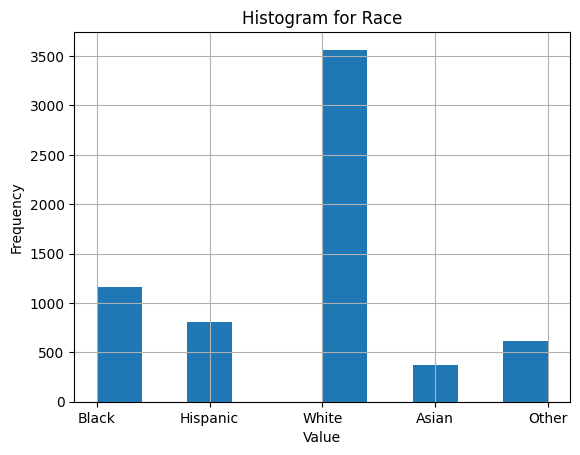

In [8]:
#check current distribution of race without the null values

train_nonullrace = train.copy()
train_nonullrace.dropna(subset=['patient_race'], inplace=True)
plt.figure()  # Create a new figure for each histogram
train_nonullrace['patient_race'].hist()
plt.title('Histogram for Race')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

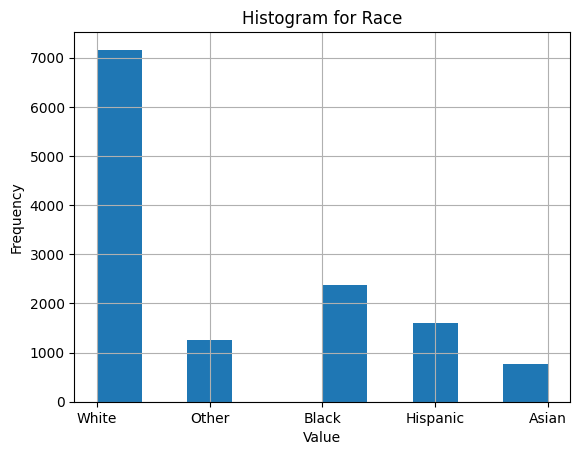

In [9]:
#replace patient_race null values randomly based on the current distribution of patient_race

distribution = train_nonullrace['patient_race'].value_counts(normalize=True)
def fill_nulls_with_random_categories(row):
    if pd.isnull(row['patient_race']):
        return np.random.choice(distribution.index, p=distribution.values)
    else:
        return row['patient_race']
train['patient_race'] = train.apply(fill_nulls_with_random_categories, axis=1)

plt.figure()  # Create a new figure for each histogram
train['patient_race'].hist()
plt.title('Histogram for Race')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [12]:
one_hot_encoder = LabelBinarizer()
one_hot_encoder.fit(train['patient_race'])
#Transform our patient_race column to 5 different binary columns corresponding to different categories
transformed = pd.DataFrame(one_hot_encoder.transform(train['patient_race']),columns=one_hot_encoder.classes_, index=train.index)
#Combine with original data frame
train = pd.concat([train,transformed], axis = 1)

['Asian' 'Black' 'Hispanic' 'Other' 'White']
Index([268700, 533188, 752174, 321576, 610225, 261644, 465345, 914339, 605031,
       933062,
       ...
       929668, 471695, 413398, 124043, 488905, 484727, 263936, 809624, 514971,
       393047],
      dtype='int64', name='patient_id', length=13169)
            Asian  Black  Hispanic  Other  White
patient_id                                      
268700          0      0         0      0      1
533188          0      0         0      1      0
752174          0      1         0      0      0
321576          0      0         0      1      0
610225          0      0         0      0      1
...           ...    ...       ...    ...    ...
484727          0      0         0      0      1
263936          0      0         0      0      1
809624          0      1         0      0      0
514971          0      1         0      0      0
393047          0      0         0      0      1

[13169 rows x 5 columns]
(13169, 151)
           patient_race  